In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)'
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras import optimizers


import cv2
import math
from IPython.display import clear_output
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../content/drive/MyDrive/Dataset/data/data/img_data"))
print(os.listdir("../content/drive/MyDrive/Dataset/data/data/video_data/test_videos"))
print(os.listdir("../content/drive/MyDrive/Fire Detection"))

print(os.listdir("../content/drive/MyDrive/Fire Detection/Resnet50"))
print(os.listdir("../content/drive/MyDrive/Fire Detection/VGG16"))

# Any results you write to the current directory are saved as output.

['test', 'train']
['test3.mp4', 'test2.mp4', 'test1.mp4']
['Resnet50', 'VGG16']
['resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'imagenet_class_index.json']
['vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'vgg16_weights_tf_dim_ordering_tf_kernels.h5', 'imagenet_class_index.json']


In [7]:
IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 3
TRAIN_BATCH_SIZE = 77
TEST_BATCH_SIZE = 1


## Model Creation



In [24]:
from keras.optimizers import Adam
def create_model( model_size ):
    my_new_model = Sequential()
    if  model_size == 'L':
        resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        resnet = ResNet50(include_top=False, pooling='avg', weights='imagenet')
        #resnet.summary()
        my_new_model.add(resnet)
        my_new_model.layers[0].trainable = False
    else:
        vgg_weights_path = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        vgg= VGG16(include_top=False, weights=vgg_weights_path )
        vgg.summary()
        my_new_model.add(vgg)
        my_new_model.add(GlobalAveragePooling2D())
        my_new_model.layers[0].trainable = False
        my_new_model.layers[1].trainable = False

    my_new_model.add(Dense(NUM_CLASSES, activation='softmax'))

    # Say no to train first layer (ResNet) model. It is already trained

    opt = Adam()
    my_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return my_new_model

## Training



In [27]:
def train_model( model ):
    #ata_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )

    train_generator = data_generator_with_aug.flow_from_directory(
            '../content/drive/MyDrive/Dataset/data/data/img_data/train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')


    validation_generator = data_generator_with_aug.flow_from_directory(
            '../content/drive/MyDrive/Dataset/data/data/img_data/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')


    #y_train = get_labels(train_generator)
    #weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
    #dict_weights = { i: weights[i] for i in range(len(weights)) }

    H = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps=1 #,
            #class_weight=dict_weights
                )

   # plot_history( H, NUM_EPOCHS )

    return model, train_generator,validation_generator

In [10]:
def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict

In [11]:
def get_labels( generator ):
    generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [12]:
def get_pred_labels( test_generator):
    test_generator.reset()
    pred_vec=model.predict_generator(test_generator,
                                     steps=test_generator.n, #test_generator.batch_size
                                     verbose=1)
    return np.argmax( pred_vec, axis = 1), np.max(pred_vec, axis = 1)


In [18]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)

    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")


    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
   # plt.plot(np.arange(0, NUM_EPOCHS), H.history["acc"], label="train_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_acc"], label="val_acc")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


    plt.show()
    #plt.savefig("plot.png")


## Prediction



In [14]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1] -600
    cv2.putText(frame, class_string, (x_start, 75), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [15]:
def prepare_image_for_prediction( img):

    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

In [25]:
model = create_model('L')

In [28]:
trained_model_l, train_generator,validation_generator = train_model(model)
label_dict_l = get_label_dict(train_generator )

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


<ipython-input-27-148d109ddf16>:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/20
9/9 [==============================] - 343s 36s/step - loss: 0.9934 - accuracy: 0.5411 - val_loss: 2.2976 - val_accuracy: 0.0000e+00
Epoch 2/20
9/9 [==============================] - 140s 15s/step - loss: 0.5244 - accuracy: 0.8153 - val_loss: 1.4508 - val_accuracy: 0.0000e+00
Epoch 3/20
9/9 [==============================] - 137s 15s/step - loss: 0.3677 - accuracy: 0.8788 - val_loss: 1.5266 - val_accuracy: 0.0000e+00
Epoch 4/20
9/9 [==============================] - 140s 15s/step - loss: 0.2991 - accuracy: 0.9163 - val_loss: 1.9393 - val_accuracy: 0.0000e+00
Epoch 5/20
9/9 [==============================] - 138s 15s/step - loss: 0.2530 - accuracy: 0.9149 - val_loss: 0.6009 - val_accuracy: 1.0000
Epoch 6/20
9/9 [==============================] - 138s 15s/step - loss: 0.2356 - accuracy: 0.9206 - val_loss: 1.4172 - val_accuracy: 0.0000e+00
Epoch 7/20
9/9 [==============================] - 134s 15s/step - loss: 0.2131 - accuracy: 0.9278 - val_loss: 1.6635 - val_accuracy: 0.0000e

In [ ]:
model = create_model('S')

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/20
9/9 [==============================] - 11s 1s/step - loss: 2.2800 - acc: 0.4257 - val_loss: 0.3528 - val_acc: 1.0000
Epoch 2/20
9/9 [==============================] - 9s 1s/step - loss: 1.5498 - acc: 0.5123 - val_loss: 0.0308 - val_acc: 1.0000
Epoch 3/20
9/9 [==============================] - 10s 1s/step - loss: 1.0122 - acc: 0.6696 - val_loss: 0.0322 - val_acc: 1.0000
Epoch 4/20
9/9 [==============================] - 10s 1s/step - loss: 0.7616 - acc: 0.7287 - val_loss: 0.0999 - val_acc: 1.0000
Epoch 5/20
9/9 [==============================] - 10s 1s/step - loss: 0.5658 - acc: 0.7994 - val_loss: 0.2316 - val_acc: 1.0000
Epoch 6/20
9/9 [==============================] - 10s 1s/step - loss: 0.4904 - acc: 0.8297 - val_loss: 0.1394 - val_acc: 1.0000
Epoch 7/20
9/9 [==============================] - 10s 1s/step - loss: 0.4593 - acc: 0.8369 - val_loss: 0.3082 - val_acc: 1.0000
Epoch 8/20
9/9 [=======

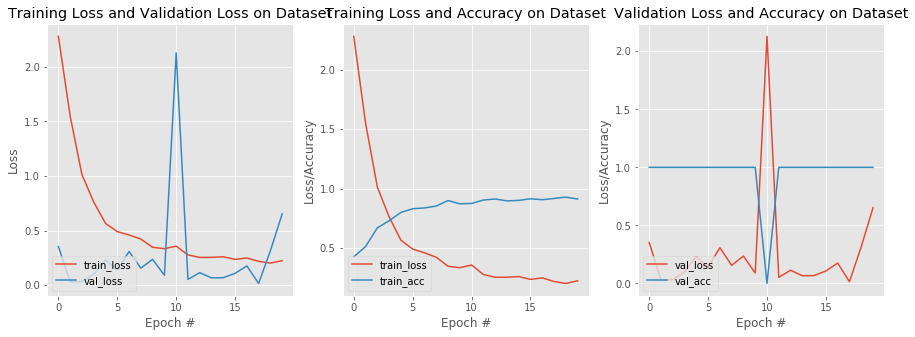

In [ ]:
#trained_model_s, train_generator,validation_generator = train_model(model)
#label_dict_s = get_label_dict(train_generator)

In [29]:
def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        txt += label_dict[c]
        if c :
            txt += '['+ str(confidence) +']'
    #print("count="+str(len(pred_class)) + " txt:" + txt)
    return txt

In [30]:

def predict(  model, video_path, filename, label_dict ):

    vs = cv2.VideoCapture(video_path)
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0

    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break

        resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
        #print(pred_vec)
        pred_class =[]
        confidence = np.round(pred_vec.max(),2)

        if confidence > 0.4:
            pc = pred_vec.argmax()
            pred_class.append( (pc, confidence) )
        else:
            pred_class.append( (0, 0) )
        if pred_class:
            txt = get_display_string(pred_class, label_dict)
            frame = draw_prediction( frame, txt )
        #print(pred_class)
        #plt.axis('off')
        #plt.imshow(frame)
        #plt.show()
        #clear_output(wait = True)
        if not writer:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            writer = cv2.VideoWriter(filename, fourcc, fps,(frame.shape[1], frame.shape[0]), True)

        # write the out
        writer.write(frame)

    vs.release()
    writer.release()



In [ ]:
#test_lables = get_test_labels( validation_generator )
#print(test_lables)

In [ ]:
#pred_lables, confidence = get_pred_labels( validation_generator )
#print( pred_lables )


In [ ]:
video_path = '../content/drive/MyDrive/Dataset/data/data/video_data/test_videos/test1.mp4'
predict ( trained_model_l, video_path, 'test1_9.avi',  label_dict_l)

video_path = '../content/drive/MyDrive/Dataset/data/data/video_data/test_videos/test2.mp4'
 predict ( trained_model_l, video_path, 'test2_9.avi',  label_dict_l)

 video_path = '../content/drive/MyDrive/Dataset/data/data/video_data/test_videos/test3.mp4'
 predict ( trained_model_l, video_path, 'test3_9.avi',  label_dict_l)

In [31]:
trained_model_l.save('Detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
